# Create Norway elevation map + MEPS area using Etopo1 and matplotlib
http://www.trondkristiansen.com/?page_id=846


https://www.ngdc.noaa.gov/mgg/global/global.html

In [1]:
import os, sys, datetime, string
sys.path.append('/uio/kant/geo-metos-u7/franzihe/Documents/Thesis/Python/')
sys.path.append('/uio/kant/geo-metos-u7/franzihe/Documents/Thesis/Python/Norway_map/')
import matplotlib.pyplot as plt

import createFolder as cF
from netCDF4 import Dataset
import numpy as np
#import laplaceFilter
#from mpl_toolkits.basemap import Basemap, cm
import matplotlib.colors as colors
import fct_maps as fcm

In [2]:
import gdal
from pyproj import Proj, transform

In [3]:
station = 'Haukeliseter'
savefig = 0   # 1 = yes, 0 = no
fig_dir = '../../Figures/Norway_map/%s' %station
form = 'png'

In [4]:
stn_lat = 59.81
stn_lon = 7.21

In [5]:
def get_kartverket_data(filename):
    inProj = Proj(init='EPSG:32633')
    outProj = Proj(init='EPSG:4326')
    
    
    gdal_data = gdal.Open(filename)
    gt = gdal_data.GetGeoTransform()

    gdal_band = gdal_data.GetRasterBand(1)
    nodataval = gdal_band.GetNoDataValue()

    # convert to a numpy array
    data_array = gdal_data.ReadAsArray().astype(np.float)

    # replace missing values if necessary
    if np.any(data_array == nodataval):
        data_array[data_array == nodataval] = np.nan


    xres = gt[1]
    yres = gt[5]

    x = np.arange(gt[0], gt[0]+data_array.shape[1]*xres, xres)
    y = np.arange(gt[3], gt[3]+data_array.shape[0]*yres, yres)
    X, Y = np.meshgrid(x,y)

    lon1, lat1 = X,Y
    
    lono1, lato1 = transform(inProj, outProj, lon1,lat1)
    return(lono1, lato1, data_array)

In [6]:
lon1, lat1, data_array1 = get_kartverket_data('6600_1_10m_z33.tif')
lon2, lat2, data_array2 = get_kartverket_data('6600_2_10m_z33.tif')
lon3, lat3, data_array3 = get_kartverket_data('6600_3_10m_z33.tif')
lon4, lat4, data_array4 = get_kartverket_data('6600_4_10m_z33.tif')

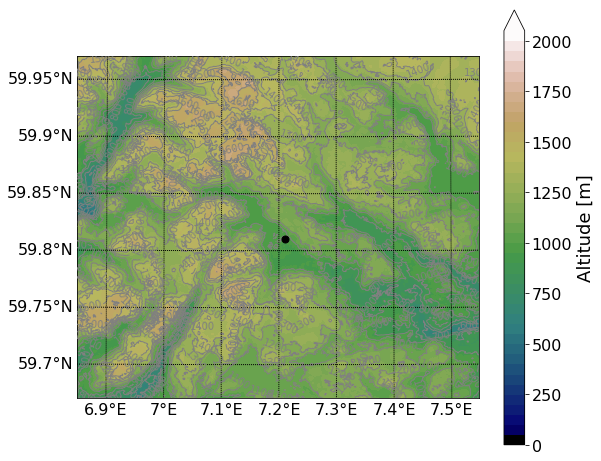

In [7]:
fig = plt.figure(figsize=(9,8))
plt.clf()

map=fcm.Lambert_map(lllon=6.85, lllat=59.67, 
                  urlon=7.55, urlat=59.97, 
                  lat0= stn_lat, lon0= stn_lon, res='l', fill=False,zoom=True)

LON1, LAT1 = map(lon1, lat1)
LON2, LAT2 = map(lon2, lat2)
LON3, LAT3 = map(lon3, lat3)
LON4, LAT4 = map(lon4, lat4)

levels = np.arange(0,2100,50)

fcm.PlotContours(LON1, LAT1, data_array1, map, leveldist=None, levels=levels[::2], numbers=True, color = 'gray')
fcm.PlotContours(LON2, LAT2, data_array2, map, leveldist=None, levels=levels[::2], numbers=True, color = 'gray')
fcm.PlotContours(LON3, LAT3, data_array3, map, leveldist=None, levels=levels[::2], numbers=True, color = 'gray')
fcm.PlotContours(LON4, LAT4, data_array4, map, leveldist=None, levels=levels[::2], numbers=True, color = 'gray')

norm = colors.BoundaryNorm(boundaries = levels, ncolors=plt.cm.gist_earth.N)

cs = map.contourf(LON1, LAT1, data_array1, levels,norm=norm, cmap=plt.cm.gist_earth, extend='max')
map.contourf(LON2, LAT2, data_array2, levels,norm=norm, cmap=plt.cm.gist_earth, extend='max')
map.contourf(LON3, LAT3, data_array3, levels,norm=norm, cmap=plt.cm.gist_earth, extend='max')
map.contourf(LON4, LAT4, data_array4, levels,norm=norm, cmap=plt.cm.gist_earth, extend='max')



cb = plt.colorbar(cs, boundaries=levels, extend='max')
cb.set_label('Altitude [m]', size=18)
cb.ax.tick_params(labelsize=16)
plt.gca().set_aspect('equal', adjustable='box')

cb.ax.set_xticklabels(np.arange(700,2100,50)[::4])

xpt, ypt = map(stn_lon, stn_lat)
map.plot(xpt, ypt, 'ko', markersize = 7)

if savefig == 1:
    cF.createFolder(fig_dir)
    fig_name = 'elevation_Haukeli.'+form
    plt.savefig('%s/%s' %(fig_dir,fig_name), format = form, bbox_inches = 'tight')
    print('plot saved: %s/%s' %(fig_dir,fig_name))
else:
    plt.show()
plt.close()